In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

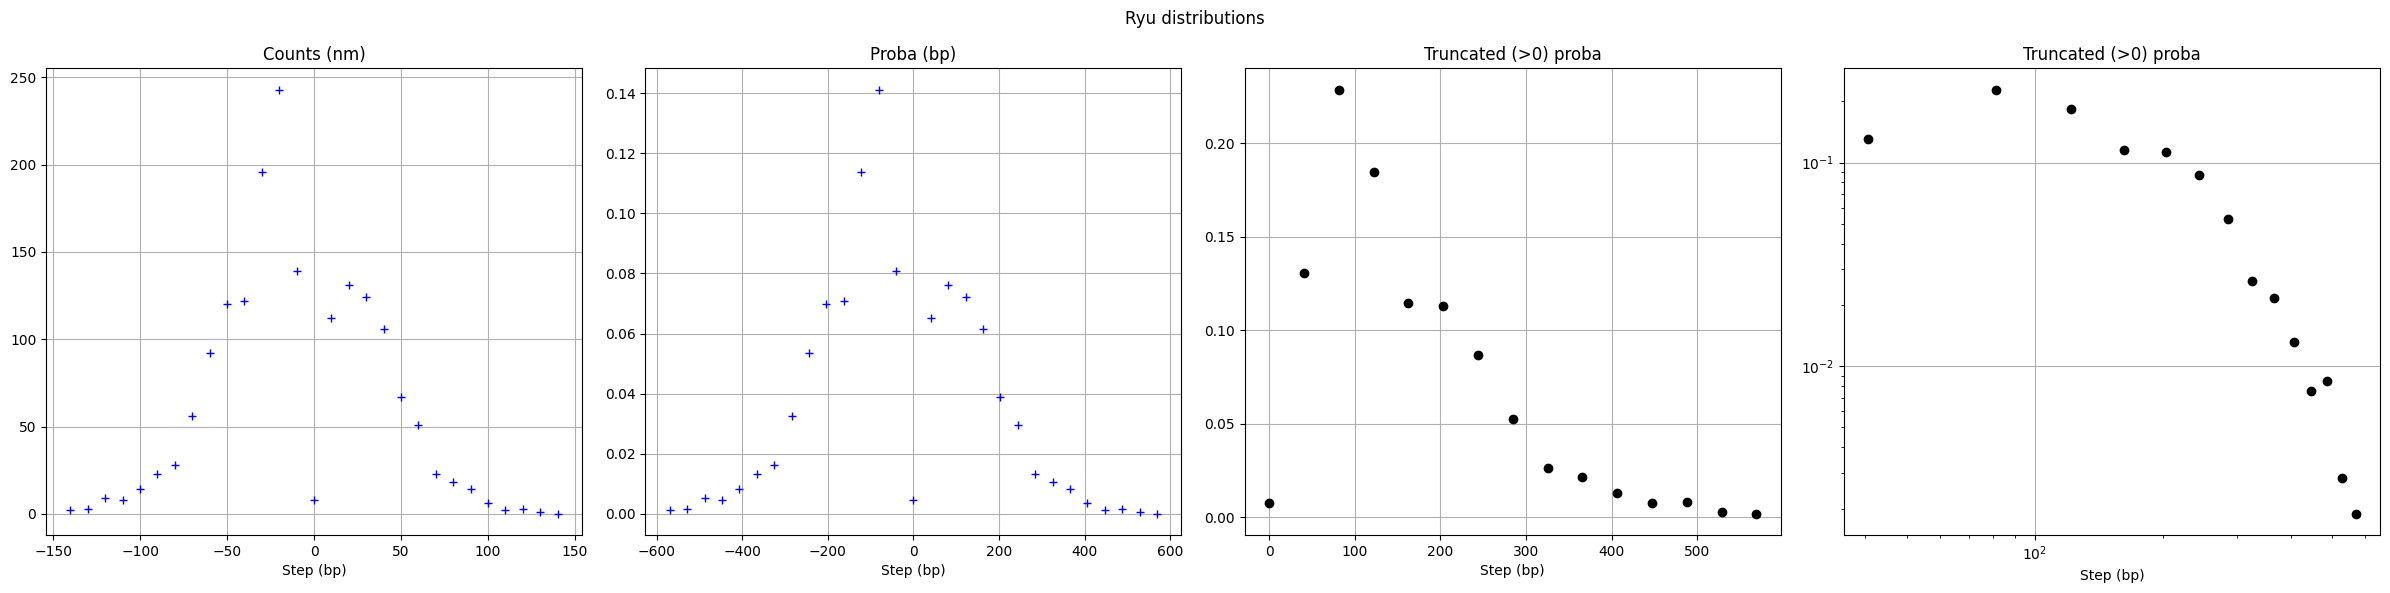

Bin width computed: 41

Extracted medians from XLSX:
 [195.12195122 129.87012987  81.30081301  78.125       75.75757576
  37.17472119  34.96503497]

Published medians from paper:
 [200 170 100 130 100  90  70]


In [5]:
# --- RYU CLEANED UTILITIES --- #

def convert_and_normalize(df: pl.DataFrame, conv: float = 0.246):
    """Convert nm to bp and normalize counts."""
    x_nm = df['Step size (nm)'].to_numpy()
    y_counts = df['Count'].to_numpy()
    x_bp = x_nm / conv
    y_probs = y_counts / np.sum(y_counts)
    return x_nm, x_bp, y_counts, y_probs

def truncate_positive_bp(x_bp: np.ndarray, y_prob: np.ndarray):
    """Keep only positive steps and renormalize."""
    mask = x_bp <= 0
    x = -x_bp[mask][::-1]
    y = y_prob[mask][::-1]
    return x, y / np.sum(y)

def plot_ryu_data(x_nm, x_bp, y_counts, y_probs, ryu_x, ryu_y):
    """Visualize original and truncated Ryu distributions."""
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    axs[0].plot(x_nm, y_counts, '+b'); axs[0].set_title("Counts (nm)")
    axs[1].plot(x_bp, y_probs, '+b'); axs[1].set_title("Proba (bp)")
    for ax in axs[2:]:
        ax.plot(ryu_x, ryu_y, 'ok'); ax.set_title("Truncated (>0) proba")
    axs[3].set_xscale("log"); axs[3].set_yscale("log")
    for ax in axs: ax.grid(True); ax.set_xlabel("Step (bp)")
    plt.suptitle("Ryu distributions"); plt.tight_layout(); plt.show()

def bin_width(ryu_x):
    """Return bin width from truncated x."""
    return int(np.round(np.diff(ryu_x)[0]))


# --- RYU MEDIAN UTILS --- #

def clean_ryu_sheet(df: pl.DataFrame, only_forward=True) -> pl.DataFrame:
    """Clean Ryu sheet and optionally flip negatives."""
    rename = {
        "__UNNAMED__0": "Step size (nm)", "Count": "F = 1 pN",
        "__UNNAMED__2": "F = 0.7 pN", "__UNNAMED__3": "F = 0.6 pN",
        "__UNNAMED__4": "F = 0.5 pN", "__UNNAMED__5": "F = 0.4 pN",
        "__UNNAMED__6": "F = 0.3 pN", "__UNNAMED__7": "F = 0.2 pN",
    }
    df = df.slice(1).rename(rename)
    df = df.with_columns([pl.col(c).cast(pl.Float64) for c in df.columns])
    order = ["Step size (nm)"] + sorted([c for c in df.columns if c != "Step size (nm)"])
    df = df.select(order)
    if only_forward:
        df = df.filter(pl.col("Step size (nm)") <= 0)
        df = df.with_columns(( -pl.col("Step size (nm)") ).alias("Step size (nm)"))
    return df

def extract_medians(df: pl.DataFrame, conv_map: dict) -> np.ndarray:
    """Extract and normalize medians from Ryu df."""
    x = df["Step size (nm)"].to_numpy()
    medians = []
    for col in df.columns[1:]:
        z = df[col].to_numpy()
        y = np.copy(z)
        y /= np.sum(y)
        idx = np.searchsorted(np.cumsum(y), 0.5)
        medians.append(x[idx] / conv_map[col])
    return np.array(medians)

# --- MEDIANS CSV UTIL --- #

def read_medians_csv(path="all_medians.csv"):
    """Read medians CSV as Polars DataFrame."""
    try:
        df = pl.read_csv(path)
        pl.Config.set_tbl_cols(len(df.columns))
        print(f"CSV loaded: {path}")
        return df
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return None


# --- MAIN --- #

# Ligne 1 : données de la figure 3B (distribution)
df_force_3B = pl.read_excel("/home/nicolas/Documents/Progs/ryu_datas.xlsx", sheet_name="Fig. 3B")
x_nm, x_bp, y_counts, y_probs = convert_and_normalize(df_force_3B)
ryu_x, ryu_y = truncate_positive_bp(x_bp, y_probs)
plot_ryu_data(x_nm, x_bp, y_counts, y_probs, ryu_x, ryu_y)
ryu_bin = bin_width(ryu_x)
print(f"Bin width computed: {ryu_bin}")

# Ligne 2 : données de la figure 3E / S5B (médianes)
df_force_3E = pl.read_excel("/home/nicolas/Documents/Progs/ryu_datas.xlsx", sheet_name="Fig. 3E S5B")
df_cleaned = clean_ryu_sheet(df_force_3E, only_forward=True)

# Conversion pour chaque force (nm -> bp)
force_to_conv = {
    "F = 0.2 pN": 0.205,
    "F = 0.3 pN": 0.231,
    "F = 0.4 pN": 0.246,
    "F = 0.5 pN": 0.256,
    "F = 0.6 pN": 0.264,
    "F = 0.7 pN": 0.269,
    "F = 1 pN":   0.286,
}

medians_xlsx = extract_medians(df_cleaned, conv_map=force_to_conv)
print("\nExtracted medians from XLSX:\n", medians_xlsx)

# Optionnel : valeurs publiées dans l'article
ryu_medians = np.array([200, 170, 100, 130, 100, 90, 70])
print("\nPublished medians from paper:\n", ryu_medians)


In [11]:
import json
import numpy as np


data = {"paper": ryu_medians, "calculated": medians_xlsx}
for key, value in data.items():
    if isinstance(value, np.ndarray):
        data[key] = value.tolist()
file_name = "ryu_medians.json"

with open(file_name, "w") as f:
    json.dump(data, f)

In [12]:
with open(file_name, "r") as f:
    data_r = json.load(f)
print(data_r)

{'paper': [200, 170, 100, 130, 100, 90, 70], 'calculated': [195.1219512195122, 129.87012987012986, 81.30081300813008, 78.125, 75.75757575757575, 37.174721189591075, 34.96503496503497]}


In [13]:
import polars as pl

df_json = pl.read_json(file_name)
print(df_json)

shape: (1, 2)
┌──────────────────┬─────────────────────────────────┐
│ paper            ┆ calculated                      │
│ ---              ┆ ---                             │
│ list[i64]        ┆ list[f64]                       │
╞══════════════════╪═════════════════════════════════╡
│ [200, 170, … 70] ┆ [195.121951, 129.87013, … 34.9… │
└──────────────────┴─────────────────────────────────┘


# .